In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import os
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from scipy.interpolate import make_interp_spline
import re
import math
from pathlib import Path
import sys
sys.path.insert(0, r'..\tools')
from scan import scan_file
from convolve_smooth import smooth_con
from smooth import smooth

[]


['15#sleepstage_counts.xlsx', '16#sleepstage_counts.xlsx', '5#sleepstage_counts.xlsx', '6#sleepstage_counts.xlsx', '62#sleepstage_counts.xlsx', '63#sleepstage_counts.xlsx', '65#sleepstage_counts.xlsx']
15#sleepstage_counts.xlsx
16#sleepstage_counts.xlsx
5#sleepstage_counts.xlsx
6#sleepstage_counts.xlsx
62#sleepstage_counts.xlsx
63#sleepstage_counts.xlsx
65#sleepstage_counts.xlsx


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


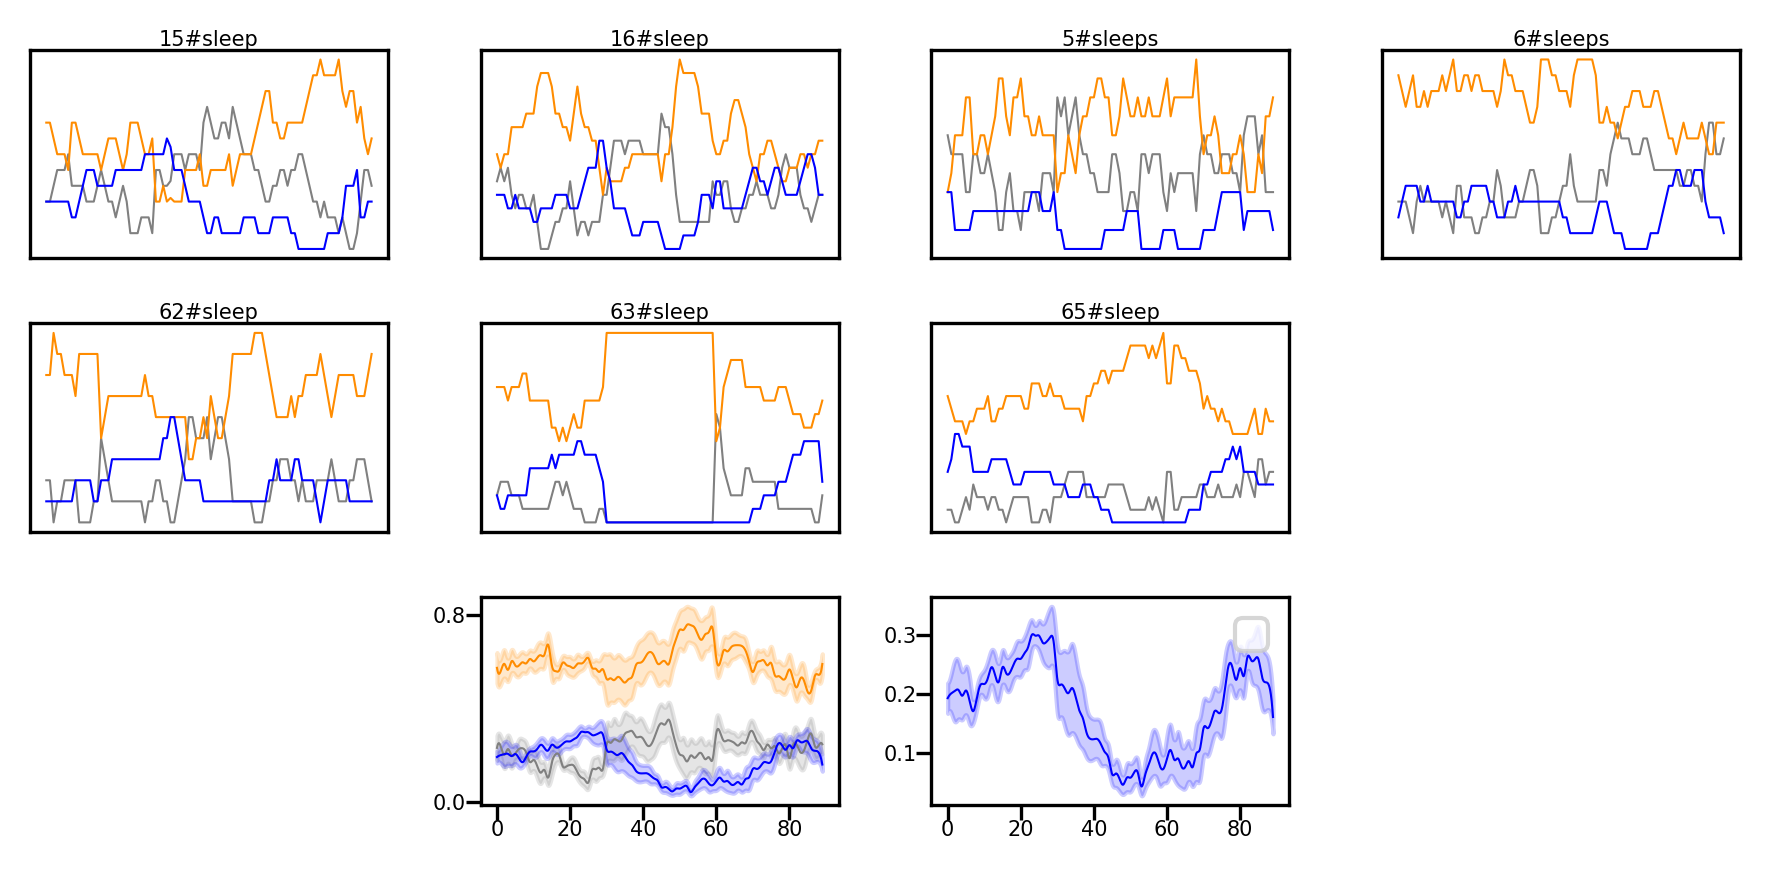

In [3]:
# %matplotlib qt

###各个睡眠阶段作图
if __name__ == '__main__':
    path = r'.\allmouse_stagecount'
    outpath = os.path.dirname(path)
    condition='n'
    filename = os.listdir(path)  ##os.listdir(a)表示返回文件夹里面的所有的文件夹或者文件的名字
    sorted_files = sorted(filename, key=lambda f: f[5:6])

    file = [x for x in sorted_files if x.endswith('stage_counts.xlsx')]
    print(file)
    arr_wake = np.ones((90, len(file))).astype(float)  # 3x4数组
    arr_NREM = np.ones((90, len(file))).astype(float)
    arr_REM = np.ones((90, len(file))).astype(float)
    before_wake, stim_wake = [], []
    before_NREM, stim_NREM = [], []
    before_REM, stim_REM = [], []

    plt.figure(figsize=(6, 3), dpi=300)

    mean_perc={'before':[],'after':[]}
    for i, filename_i in enumerate(file):
        print(filename[i])
        plt.subplot(3, 4, i + 1)
        df=pd.read_excel(path + '\\' + file[i])
        arr_wake[:, i] = df['%wake'].values.tolist()  # prefix="F"
        before_wake.append(np.mean(arr_wake[:, i][0:30]))
        stim_wake.append(np.mean(arr_wake[:, i][30:60]))

        arr_NREM[:, i] =df['%nonREM'].values.tolist()  # prefix="F"
        before_NREM.append(np.mean(arr_NREM[:, i][0:30]))
        stim_NREM.append(np.mean(arr_NREM[:, i][30:60]))

        arr_REM[:, i] =df['%rem'].values.tolist()  ##prefix="F"
        before_REM.append(np.mean(arr_REM[:, i][0:30]))
        stim_REM.append(np.mean(arr_REM[:, i][30:60]))

        plt.plot(np.arange(0, 90, 1), arr_wake[:, i],'gray',lw=0.5)
        plt.plot(np.arange(0, 90, 1), arr_NREM[:, i],'darkorange',lw=0.5)
        plt.plot(np.arange(0, 90, 1), arr_REM[:, i],'blue',lw=0.5)
        plt.title(filename_i[:8],fontsize=5,pad=0.08)
        plt.xticks([])
        plt.yticks([])
    # plt.legend()
    # plt.show()
    ###刺激前和刺激后的幅度均值
    mean = {'before_wake': before_wake, 'stim_wake': stim_wake, "before_NREM": before_NREM, 'stim_NREM': stim_NREM,
            'before_REM': before_REM, 'stim_REM': stim_REM}
    pd.DataFrame(mean).to_excel(path + '\\before&stim_mean.xlsx')  # before和stim比较

    mean_wake = arr_wake.mean(axis=1)
    # pd.DataFrame(mean_wake).to_excel(path+'wake_mean.xlsx')
    std_wake = np.array(arr_wake.std(axis=1, ddof=1)) / (math.sqrt(len(file)))
    mean_NREM = arr_NREM.mean(axis=1)
    # pd.DataFrame(mean_NREM).to_excel(path+'NREM_mean.xlsx')
    std_NREM = np.array(arr_NREM.std(axis=1, ddof=1)) / (math.sqrt(len(file)))
    mean_REM = arr_REM.mean(axis=1)
    # pd.DataFrame(mean_REM).to_excel(path+'REM_mean.xlsx')
    std_REM = np.array(arr_REM.std(axis=1, ddof=1)) / (math.sqrt(len(file)))

    x = np.arange(0, 90, 1)
    x_smooth = np.linspace(x.min(), x.max(), 1200)
    meanwake_smooth = make_interp_spline(x, mean_wake)(x_smooth)
    stdwake_smooth = make_interp_spline(x, std_wake)(x_smooth)
    meanNREM_smooth = make_interp_spline(x, mean_NREM)(x_smooth)
    stdNREM_smooth = make_interp_spline(x, std_NREM)(x_smooth)
    meanREM_smooth = make_interp_spline(x, mean_REM)(x_smooth)
    stdREM_smooth = make_interp_spline(x, std_REM)(x_smooth)
###对数据进行sooth处理
    if condition=='y':
        meanwake_smooth=smooth_con(meanwake_smooth,35)
        stdwake_smooth=smooth_con(stdwake_smooth,35)
        meanNREM_smooth=smooth_con(meanNREM_smooth,35)
        stdNREM_smooth=smooth_con(stdNREM_smooth,35)
        meanREM_smooth=smooth_con(meanREM_smooth,35)
        stdREM_smooth=smooth_con(stdREM_smooth,35)

    plt.subplot(3, 4, 10)
    plt.plot(x_smooth, meanwake_smooth,'gray',lw=0.5)
    plt.fill_between(x_smooth, meanwake_smooth - stdwake_smooth, meanwake_smooth + stdwake_smooth,
                     color='gray', alpha=0.2, label='wake')
    plt.plot(x_smooth, meanNREM_smooth,'darkorange',lw=0.5)
    plt.fill_between(x_smooth, meanNREM_smooth - stdNREM_smooth, meanNREM_smooth + stdNREM_smooth,
                     color='darkorange', alpha=0.2, label='NREM')
    plt.plot(x_smooth, meanREM_smooth, 'blue',lw=0.5)
    plt.fill_between(x_smooth, meanREM_smooth - stdREM_smooth, meanREM_smooth + stdREM_smooth,
                     color='blue', alpha=0.2, label='REM')
    # plt.xticks([])
    plt.yticks([0,0.8])
    plt.tick_params(labelsize=5,pad=0.03)

    plt.subplot(3, 4, 11)
    plt.plot(x_smooth, meanREM_smooth, 'blue',lw=0.5)
    plt.fill_between(x_smooth, meanREM_smooth - stdREM_smooth, meanREM_smooth + stdREM_smooth,
                     color='blue', alpha=0.2)   ##label='REM'
    plt.tick_params(labelsize=5,pad=0.03)   ##同时设置x,y轴标签大小和距离刻度位置
    plt.legend()
    plt.tight_layout()
    plt.savefig(path + '\\sleeppercentage.pdf',dpi=600)
    plt.show()